# 每年每月參與的 Tweets 與 Twitter 數量
#### 日期格式要透過 timeshift 來調整(將淺顯易懂的時間格式轉換成 G8 的 Twitter 格式)
##### 參考來源：http://strftime.org/
#### 使用 calendar 的 monthrange 套件將每個月的邊界找出來，然後使用 for 迴圈將每個月的資料拉出來
##### 參考來源：http://stackoverflow.com/questions/4938429/how-do-we-determine-the-number-of-days-for-a-given-month-in-python

In [1]:
import pyes
from datetime import datetime
from calendar import monthrange

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

# 用來把簡單的時間轉換成超複雜的Twitter用時間
def dtConvert(s):
    date_object = datetime.strptime(s, '%Y %m %d %X') # 定義輸入進來的簡單時間格式
    dt_str = date_object.ctime() # 把格式轉換成 Twitter 的 G8 時間格式(但時區未包含在內)
    dt_list = dt_str.split() # 為了把時區塞進去，要先把 String 切成 list
    dt_list.insert(4, '+0000') # 在 list 中的第四個位置塞入時區資料
    dt_result = ' '.join(dt_list) # 把 list 轉回 string 並以空白區隔
    return dt_result # 完成並回傳結果

# 將某月的資料爬出來並計算結果
def queryResult(Sfrom, Sto):
    q = pyes.query.BoolQuery()
    ESR = pyes.ESRange(field="created_at", from_value=Sfrom, to_value=Sto, include_lower=True ,include_upper=True)
    rq = pyes.query.RangeQuery(qrange=ESR)
    q.add_must(rq)
    
    result = None
    result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 
    print "Tweets 數量:",
    print len(result), # 未過濾重複發文者的id

    storage = set() # 用 set 來儲存不重複的元素
    for x in result:
        if 'uid' in x:                          # 2014年7月有一筆資料的 uid Missing，所以用 if 來處理並忽略。
            storage.add(x['uid'])
    print ", Twitter 數量:",
    print len(storage) # 過濾重複發文者的id
    return

# 主程式
# 資料從2008年2月1日開始到2015年7月31日
for y in range(2008, 2016):
    for m in range(1, 13):
        print (y, m),
        print "\t",
        dt_from = [y, m, '1', '00:00:00']
        dt_to = [y, m, monthrange(y, m)[1], '23:59:59']
        Sdt_from = dtConvert(' '.join(str(v) for v in dt_from))
        Sdt_to = dtConvert(' '.join(str(v) for v in dt_to))
        queryResult(Sdt_from, Sdt_to)

(2008, 1) 	Tweets 數量: 0 , Twitter 數量: 0
(2008, 2) 	Tweets 數量: 3 , Twitter 數量: 2
(2008, 3) 	Tweets 數量: 89 , Twitter 數量: 2
(2008, 4) 	Tweets 數量: 96 , Twitter 數量: 2
(2008, 5) 	Tweets 數量: 51 , Twitter 數量: 3
(2008, 6) 	Tweets 數量: 20 , Twitter 數量: 2
(2008, 7) 	Tweets 數量: 93 , Twitter 數量: 4
(2008, 8) 	Tweets 數量: 93 , Twitter 數量: 4
(2008, 9) 	Tweets 數量: 128 , Twitter 數量: 5
(2008, 10) 	Tweets 數量: 147 , Twitter 數量: 6
(2008, 11) 	Tweets 數量: 114 , Twitter 數量: 6
(2008, 12) 	Tweets 數量: 305 , Twitter 數量: 10
(2009, 1) 	Tweets 數量: 270 , Twitter 數量: 11
(2009, 2) 	Tweets 數量: 303 , Twitter 數量: 11
(2009, 3) 	Tweets 數量: 484 , Twitter 數量: 14
(2009, 4) 	Tweets 數量: 673 , Twitter 數量: 15
(2009, 5) 	Tweets 數量: 753 , Twitter 數量: 16
(2009, 6) 	Tweets 數量: 711 , Twitter 數量: 16
(2009, 7) 	Tweets 數量: 695 , Twitter 數量: 15
(2009, 8) 	Tweets 數量: 689 , Twitter 數量: 17
(2009, 9) 	Tweets 數量: 654 , Twitter 數量: 15
(2009, 10) 	Tweets 數量: 856 , Twitter 數量: 17
(2009, 11) 	Tweets 數量: 1059 , Twitter 數量: 19
(2009, 12) 	Tweets 數量: 100

# 建立每年每月參與的 Tweets 與 Twitter 數量表格
#### 先把 pyes 抓出來的資料使用 pandas 轉換為表格
##### 參考來源：http://pandas.pydata.org/pandas-docs/stable/dsintro.html#from-dict-of-ndarrays-lists
#### 再將兩個表格合併
##### 參考來源：http://stackoverflow.com/questions/18062135/combining-two-series-into-a-dataframe-in-pandas
#### 丟到 Seaborn 使用。
##### 參考來源：https://uqer.io/community/share/56580632f9f06c6cc191ad4b

In [2]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")
import pyes
from datetime import datetime
from calendar import monthrange

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

Year_Month = []
Month_Twitter = []
Month_Tweets = []

# 用來把簡單的時間轉換成超複雜的Twitter用時間
def dtConvert(s):
    date_object = datetime.strptime(s, '%Y %m %d %X') # 定義輸入進來的簡單時間格式
    dt_str = date_object.ctime() # 把格式轉換成 Twitter 的 G8 時間格式(但時區未包含在內)
    dt_list = dt_str.split() # 為了把時區塞進去，要先把 String 切成 list
    dt_list.insert(4, '+0000') # 在 list 中的第四個位置塞入時區資料
    dt_result = ' '.join(dt_list) # 把 list 轉回 string 並以空白區隔
    return dt_result # 完成並回傳結果

# 將某月的資料爬出來並計算結果
def queryResult(Sfrom, Sto, Y, M):
    q = pyes.query.BoolQuery()
    ESR = pyes.ESRange(field="created_at", from_value=Sfrom, to_value=Sto, include_lower=True ,include_upper=True)
    rq = pyes.query.RangeQuery(qrange=ESR)
    q.add_must(rq)
    result = None
    result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 
    
    # 將傳進來的年月資料放進 list 中，再轉為 String 放回 Year_Month 這個 list 中，用來當表格的 index。
    YM = [Y, M]
    Year_Month.append('-'.join(str(v) for v in YM))
    
    # 將每個月的 Tweets 數量寫入 list。
    Month_Tweets.append(len(result))

    # 將每個月的 Twitter 數量寫入 list。
    storage = set() # 用 set 來儲存不重複的元素。
    for x in result:
        if 'uid' in x:                          # 2014年7月有一筆資料的 uid Missing，所以用 if 來處理並忽略。
            storage.add(x['uid'])
    Month_Twitter.append(len(storage))
    return

# 主程式
# 資料從2008年2月1日開始到2015年7月31日
for y in range(2008, 2016):
    for m in range(1, 13):
        dt_from = [y, m, '1', '00:00:00']
        dt_to = [y, m, monthrange(y, m)[1], '23:59:59']
        Sdt_from = dtConvert(' '.join(str(v) for v in dt_from))
        Sdt_to = dtConvert(' '.join(str(v) for v in dt_to))
        queryResult(Sdt_from, Sdt_to, y, m)

# 輸出結果矩陣
s0 = pd.Series(Year_Month, name = 'year-month')
s1 = pd.Series(Month_Tweets, name = 'Tweets')
s2 = pd.Series(Month_Twitter, name = 'Twitter') # , index = Year_Month
barResult = pd.concat([s0, s1, s2], axis=1)
print "Done"

Done


# 每年每月參與的 Twitter 數量長條圖

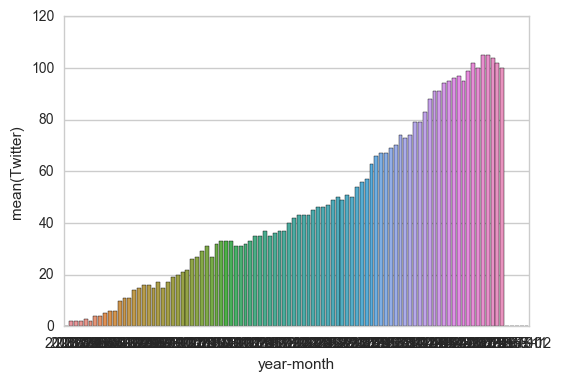

In [3]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline
sb.barplot(x='year-month', y='Twitter', order=Year_Month, data=barResult)

# 每年每月參與的 Tweets 數量長條圖

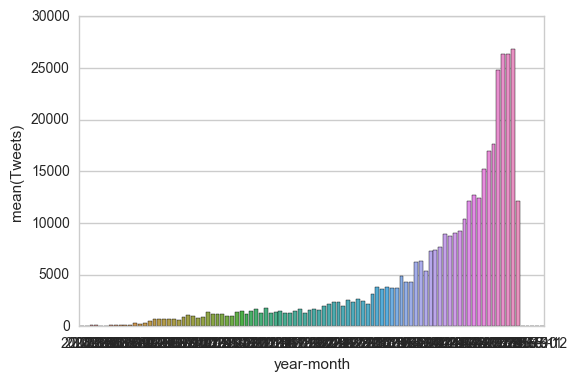

In [4]:
%matplotlib inline
sb.barplot(x='year-month', y='Tweets', order=Year_Month, data=barResult)

# 不論年份的每月參與 Tweets 與 Twitter 數量長條圖

In [5]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")
import pyes
from datetime import datetime
from calendar import monthrange

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

Month = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
AllMonth_Twitter = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
AllMonth_Tweets = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# 用來把簡單的時間轉換成超複雜的Twitter用時間
def dtConvert(s):
    date_object = datetime.strptime(s, '%Y %m %d %X') # 定義輸入進來的簡單時間格式
    dt_str = date_object.ctime() # 把格式轉換成 Twitter 的 G8 時間格式(但時區未包含在內)
    dt_list = dt_str.split() # 為了把時區塞進去，要先把 String 切成 list
    dt_list.insert(4, '+0000') # 在 list 中的第四個位置塞入時區資料
    dt_result = ' '.join(dt_list) # 把 list 轉回 string 並以空白區隔
    return dt_result # 完成並回傳結果

# 將某月的資料爬出來並計算結果
def queryResult(Sfrom, Sto, Y, M):
    q = pyes.query.BoolQuery()
    ESR = pyes.ESRange(field="created_at", from_value=Sfrom, to_value=Sto, include_lower=True ,include_upper=True)
    rq = pyes.query.RangeQuery(qrange=ESR)
    q.add_must(rq)
    result = None
    result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 
    
    # 將每個月的 Tweets 數量寫入 list。
    AllMonth_Tweets[M-1] = AllMonth_Tweets[M-1] + len(result)

    # 將每個月的 Twitter 數量寫入 list。
    storage = set() # 用 set 來儲存不重複的元素。
    for x in result:
        if 'uid' in x:                          # 2014年7月有一筆資料的 uid Missing，所以用 if 來處理並忽略。
            storage.add(x['uid'])
    AllMonth_Twitter[M-1] = AllMonth_Twitter[M-1] + len(storage)
    return

# 主程式
# 資料從2008年2月1日開始到2015年7月31日
for y in range(2008, 2016):
    for m in range(1, 13):
        dt_from = [y, m, '1', '00:00:00']
        dt_to = [y, m, monthrange(y, m)[1], '23:59:59']
        Sdt_from = dtConvert(' '.join(str(v) for v in dt_from))
        Sdt_to = dtConvert(' '.join(str(v) for v in dt_to))
        queryResult(Sdt_from, Sdt_to, y, m)

# 輸出結果矩陣
s0 = pd.Series(Month, name = 'Month')
s1 = pd.Series(AllMonth_Twitter, name = 'Tweets')
s2 = pd.Series(AllMonth_Twitter, name = 'Twitter')
barResult = pd.concat([s0, s1, s2], axis=1)
print "Done"

Done


# 不論年份的每月參與 Twitter 數量長條圖

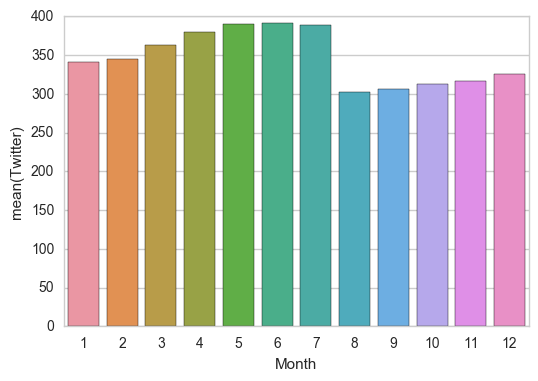

In [6]:
%matplotlib inline
sb.barplot(x='Month', y='Twitter', order=Month, data=barResult)

# 不論年份的每月參與 Tweets 數量長條圖

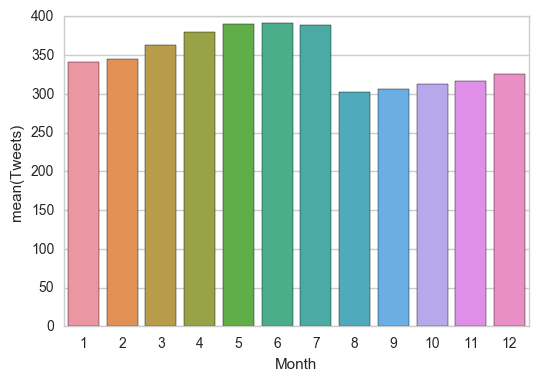

In [7]:
%matplotlib inline
sb.barplot(x='Month', y='Tweets', order=Month, data=barResult)